# Assignment 4

The objective of this assignment is to introduce you to federated learning, with a particular focus on the challenges posed by data heterogeneity. Specifically, you will explore well-known approaches for addressing statistical heterogeneity, approaching the problem from multiple angles.

You have been provided with a manual that includes detailed descriptions of each task. Follow the instructions in the manual carefully, and add your answers and implementations directly in this notebook.

Note: In this assignment, we concentrate on one common type of statistical heterogeneity: label skew. While feature skew is another significant aspect of heterogeneity, it will not be the focus of this assignment.

In [10]:
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()


In [12]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)
    
    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task 1: Centralized Vs Federated Scenario

In this task, you will analyze the theoretical equivalence between FedSGD and a centralized training scenario. The code for both implementations has been provided. To minimize differences caused by floating-point precision, a batch size of 1 is used, along with full-batch gradient descent. You may change the device to cpu if you wish, as gpu will not be utilized for batch size of 1.

Since we are working with batch size 1 and full-batch gradient descent, accuracy is not the focus here. Instead, you will monitor gradient divergence by tracking the sum or magnitude of the gradients at each round and observe how they evolve in both settings.

Theoretically, FedSGD and centralized training should yield equivalent results. However, in this task, you may observe discrepancies. Your objective is to understand the code and identify the error that causes this divergence. You may want to review why FedSGD and full-batch centralized gradient descent are theoretically equivalent by revisiting the gradient descent steps on the global objective, as covered in class. Finally, assess whether the code aligns with these theoretical steps. If you believe they should not be equivalent, provide a reasoned justification.

In [14]:
num_clients = 5
dirichlet_alpha = 0.8
batch_size = 1

# Partition data and create loaders
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, dirichlet_alpha, batch_size
)

In [55]:
def fedsgd_training(global_model, train_loaders, num_clients, rounds, lr):
    round_avg_updates = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)
    print(f"Using device: {device}")

    client_data_counts = [len(train_loader.dataset) for train_loader in train_loaders]
    total_data_count = 0
    for count in client_data_counts:
        total_data_count += count

    for round_num in range(rounds):
        client_updates = []
        print(f"Round {round_num + 1}/{rounds}")

        for client_id in range(num_clients):
            overall_update = local_train(global_model, train_loaders[client_id], lr)
            client_update_device = {name: update.to(device) for name, update in overall_update.items()}
            client_updates.append(client_update_device)

            client_update_sum = 0
            for update in client_update_device.values():
                client_update_sum += update.abs().sum().item()
            print(f"Client {client_id + 1} Update Sum at Round {round_num + 1}: {client_update_sum}")

        avg_update = {}
        for name in global_model.state_dict():
            grad_sum = torch.zeros_like(global_model.state_dict()[name], device=device)
            for client_id in range(num_clients):
                grad_sum += client_updates[client_id][name]
            avg_update[name] = grad_sum

        round_avg_updates.append(avg_update)

        avg_update_sum = 0
        for update in avg_update.values():
            avg_update_sum += update.abs().sum().item()
        print(f"Averaged Update Sum at Round {round_num + 1}: {avg_update_sum}")

        with torch.no_grad():
            for name, param in global_model.named_parameters():
                param -= avg_update[name]

    return round_avg_updates



def local_train(model, train_loader, lr):
    local_model = SimpleCNN()
    local_model.load_state_dict(model.state_dict())
    local_model.train()

    optimizer = optim.SGD(local_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    local_model.to(device)

    initial_weights = {name: param.clone() for name, param in local_model.named_parameters()}

    for epoch in range(1):
        print(f"Epoch {epoch + 1}/{1} for local client")
        optimizer.zero_grad() 
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        # Loop over batches
        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = local_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()  

    overall_update = {name: initial_weights[name] - param for name, param in local_model.named_parameters()}
    
    return overall_update


In [56]:
def centralized_training_updates(global_model, train_loader, epochs, lr):
    centralized_model = SimpleCNN()
    centralized_model.load_state_dict(global_model.state_dict())
    centralized_model.train()

    optimizer = optim.SGD(centralized_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(reduction="sum")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    centralized_model.to(device)

    epoch_updates = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_initial_weights = {name: param.clone() for name, param in centralized_model.named_parameters()}
        optimizer.zero_grad()
        batch_iterator = tqdm(train_loader, desc=f"Training Batches (Epoch {epoch + 1})")

        for x_train, y_train in batch_iterator:
            x_train, y_train = x_train.to(device), y_train.to(device)
            outputs = centralized_model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()

            batch_iterator.set_postfix(loss=loss.item())

        optimizer.step()

        epoch_update = {name: param - epoch_initial_weights[name]  for name, param in centralized_model.named_parameters()}
        epoch_updates.append(epoch_update)

        epoch_update_sum = 0
        for update in epoch_update.values():
            epoch_update_sum += update.abs().sum().item()
            
        print(f"Epoch {epoch + 1} Update Sum: {epoch_update_sum}")

    global_model.load_state_dict(centralized_model.state_dict())

    return epoch_updates


In [50]:
# Initialize model and parameters
rounds = 4
lr = 1e-4
initial_model = SimpleCNN()

In [ ]:
# Centralized Training
global_model_centralized = SimpleCNN()
global_model_centralized.load_state_dict(initial_model.state_dict())
centralized_updates = centralized_training_updates(global_model_centralized, train_centralized_loader, epochs=rounds, lr=lr)

In [ ]:
# Fedsgd
global_model_fedsgd = SimpleCNN()
global_model_fedsgd.load_state_dict(initial_model.state_dict())
fedsgd_avg_updates = fedsgd_training(global_model_fedsgd, federated_train_loaders, num_clients, rounds=rounds, lr=lr)

In [ ]:
# Calculate update magnitudes for each round
centralized_magnitudes = [sum(param.norm().item() for param in round_update.values()) for round_update in centralized_updates]
fedsgd_magnitudes = [sum(param.norm().item() for param in update.values()) for update in fedsgd_avg_updates]

# Plot update magnitudes
x_labels = range(1, rounds + 1)
width = 0.25

plt.bar([x - width for x in x_labels], centralized_magnitudes, width=width, label="Centralized")
plt.bar(x_labels, fedsgd_magnitudes, width=width, label="FedSGD")
plt.xlabel("Round")
plt.ylabel("Average Update Magnitude")
plt.title("Update Magnitude Comparison Across Methods")
plt.legend()
plt.show()

# Check if the gradients are approximately the same
tolerance = 1e-2
success = all(abs(c - f) <= tolerance for c, f in zip(centralized_magnitudes, fedsgd_magnitudes))

if success:
    print("Success! The gradients are approximately the same.")
else:
    print("Keep trying")

# Task 2: FedAvg

Implement the fedavg_training function to perform Federated Averaging (FedAvg) over multiple communication rounds. Each round, collect updates from clients by training locally on their data and average these updates to form a new global model.

Additionally, implement the local_train function to handle client-side training. You are not restricted to using full-batch gradient descent; feel free to use mini-batch gradient descent instead. Make sure your implementation aligns with the provided code to plot the accuracies, as you should not modify that code.

In [55]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy



In [ ]:
def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = [] 
    # To Do
    return round_avg_updates, round_accuracies



def local_train(model, train_loader, epochs, lr):
    overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    #To Do
    return overall_update


In the following code you may change the learning rate or the batch size

In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies

accuracies_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies = run_fedavg(alpha)
    accuracies_per_alpha.append(round_accuracies)


In [ ]:
# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
plt.show()

# Task 3: Scaffold

In this task, you will implement the SCAFFOLD algorithm, which addresses client heterogeneity through variance reduction. We will evaluate the implementation in a 0.1 Dirichlet heterogeneous setting, and accuracy plotting code is provided.

The implementation of SCAFFOLD is similar to FedAvg, with only a few additional steps at both the server and client side. For reference, you may consult the SCAFFOLD paper to understand these adjustments in detail.

In [88]:
def local_train_scaffold(model, train_loader, c_global, c_local, epochs, lr):
    overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    new_c_local = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
    # To Do
    return overall_update, new_c_local

def federated_scaffold(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr):
    round_accuracies = []
    # To Do
    return round_accuracies

In [ ]:
num_clients = 5
rounds = 3
epochs = 20
lr = 0.01
mu = 0.001

# Run federated SCAFFOLD with 0.1 Dirichlet and plot accuracy per round
def run_scaffold():
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size)
    global_model_scaffold = SimpleCNN()
    round_accuracies = federated_scaffold(global_model_scaffold, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies

# Run SCAFFOLD and get accuracy per round
scaffold_accuracies = run_scaffold()

In [ ]:
plt.figure()
plt.plot(range(1, rounds + 1), scaffold_accuracies, marker='o', label='SCAFFOLD Alpha = 0.1')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('SCAFFOLD Accuracy per Round (Dirichlet Alpha = 0.1)')
plt.legend()
plt.show()

# Task 4: Gradient Harmonization

In this task, you will examine how heterogeneity influences the gradient updates sent by each client. Specifically, you will analyze and quantify gradient conflicts at varying levels of heterogeneity.

First, implement the FedAvg code (You can reuse your task 2 implementation) and integrate the provided conflict-counting function at the end of each round to measure the number of conflicts in different heterogeneous settings.

Next, implement the Gradient Harmonization algorithm to harmonize conflicting gradients.

Finally, evaluate the performance of the harmonized gradients under a 0.1 Dirichlet scenario, and compare the number of conflicts before and after harmonization.

In [ ]:
import builtins
sum = builtins.sum

def cosine_similarity(vec1, vec2):
    return torch.dot(vec1, vec2) / (torch.norm(vec1) * torch.norm(vec2))

def gradient_conflict_counter(client_updates):
    total_conflicts = 0  # Variable to store the total conflicts across all layers
    num_clients = len(client_updates)

    # Iterate over each layer (key) in the client updates
    for layer_name in client_updates[0].keys():
        # Collect vectors for this layer across all clients
        layer_vectors = [client_update[layer_name].view(-1).cpu() for client_update in client_updates]

        # Check pairwise cosine similarity for this layer and count conflicts
        for i in range(num_clients):
            for j in range(i + 1, num_clients):
                sim = cosine_similarity(layer_vectors[i], layer_vectors[j])
                if sim < 0:
                    total_conflicts += 1

    print(f"Total gradient conflicts detected: {total_conflicts}")
    return total_conflicts

def Federated_gradient_conflict(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []  
    conflict_counts = [] 
    # To Do
    return round_avg_updates, round_accuracies, conflict_counts

In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedconflict(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies,conflict_counts = Federated_gradient_conflict(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies, conflict_counts

accuracies_per_alpha = []
conflicts_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies, conflict_counts = run_fedconflict(alpha)
    accuracies_per_alpha.append(round_accuracies)
    conflicts_per_alpha.append(conflict_counts)



In [ ]:
plt.figure(figsize=(10, 6))

for i, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), conflicts_per_alpha[i], marker='o', label=f'Alpha = {alpha}')

plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds for Different Heterogeneity Levels (Dirichlet Alphas)")
plt.legend(title="Heterogeneity Level (Alpha)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [ ]:
def gradient_harmonization(client_updates):
    # To Do
    return client_updates

def Federated_gradient_harmonization(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_accuracies = []  # List to store total accuracy after each round
    pre_harmonization_conflicts = []  # List to store conflicts before harmonization
    post_harmonization_conflicts = []  # List to store conflicts after harmonization
    # To Do
    return round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts


In [ ]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
alpha = 0.1

# Run federated gradient harmonization
train_loaders, test_loaders, _, _ = partition_data(
    train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size
)
global_model_fedavg = SimpleCNN()
round_accuracies, pre_harmonization_conflicts, post_harmonization_conflicts = Federated_gradient_harmonization(
    global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders
)

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, rounds + 1), pre_harmonization_conflicts, marker='o', linestyle='-', label='Conflicts Before Harmonization')
plt.plot(range(1, rounds + 1), post_harmonization_conflicts, marker='x', linestyle='--', label='Conflicts After Harmonization')
plt.xlabel("Rounds")
plt.ylabel("Number of Gradient Conflicts")
plt.title("Gradient Conflicts Across Rounds (Alpha = 0.1)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(range(1, rounds + 1), round_accuracies, marker='s', color='b')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Across Rounds (Alpha = 0.1)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


# Task 5: FedSam

In this task, you will explore Sharpness-Aware Minimization (SAM) in a federated learning setting by implementing the FedSAM algorithm. As with previous tasks, evaluate its performance in a 0.1 Dirichlet heterogeneous scenario.

In [56]:
# def apply_sam_perturbation(local_model, criterion, x_train, y_train, rho):
#     # To Do
#     pass

# def local_train_sam(model, train_loader, epochs, lr, rho=0.0001):
#     overall_update = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
#     # To do
#     return overall_update

# def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr):
#     round_accuracies = []
#     # To Do
#     return round_accuracies


def apply_sam_perturbation(model, criterion, x_train, y_train, rho):
    # Clone original weights to restore after perturbation
    original_weights = {name: param.detach().clone() for name, param in model.named_parameters() if param.requires_grad}

    # Forward pass and compute loss
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()  # Compute gradients

    # Perturb weights
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.requires_grad:
                grad_norm = param.grad.norm(2)
                perturbation = rho * param.grad / (grad_norm + 1e-8)
                param.add_(perturbation)  # Apply perturbation

    # Create a perturbed copy of the model
    perturbed_weights = {name: param.clone() for name, param in model.named_parameters() if param.requires_grad}

    # Restore original weights
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.requires_grad:
                param.copy_(original_weights[name])

    return perturbed_weights

def local_train_sam(model, train_loader, epochs, lr, rho=0.0001):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        for x_batch, y_batch in train_loader:
            # Forward pass with perturbed weights
            perturbed_weights = apply_sam_perturbation(model, criterion, x_batch, y_batch, rho)

            # Gradient descent on perturbed weights
            optimizer.zero_grad()
            perturbed_outputs = model(x_batch)
            loss = criterion(perturbed_outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Track and print elapsed time for each epoch
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch + 1} completed in {epoch_duration:.2f} seconds")

    # Return local updates for aggregation
    return {name: param.clone() for name, param in model.named_parameters()}

def federated_training_sam(global_model, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr, rho=0.0001):
    global_model_state = global_model.state_dict()
    round_accuracies = []

    for round in range(rounds):
        round_start_time = time.time()
        client_updates = []

        for client_id in range(num_clients):
            local_model = SimpleCNN()
            local_model.load_state_dict(global_model_state)

            # Track progress for each client's local training
            local_update = local_train_sam(local_model, train_loaders[client_id], epochs, local_lr, rho)
            client_updates.append(local_update)

        # Aggregate updates
        global_model_state = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                              for name in global_model_state}

        global_model.load_state_dict(global_model_state)

        # Evaluate global model
        client_accuracies, total_accuracy = evaluate_model(global_model, test_loaders)
        round_accuracies.append(total_accuracy)

        # Print round completion information
        round_end_time = time.time()
        round_duration = round_end_time - round_start_time
        print(f"Round {round + 1}: Accuracy = {total_accuracy:.4f}, Time: {round_duration:.2f} seconds")

    return round_accuracies


def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy





In [57]:
# Run the FedSAM experiment
num_clients = 5
rounds = 3
epochs = 1
lr = 0.001

def run_fedsam():
    # Partition data with a Dirichlet alpha of 0.1
    train_loaders, test_loaders, _, _ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, 0.1, batch_size)
    global_model_sam = SimpleCNN()
    round_accuracies = federated_training_sam(global_model_sam, train_loaders, test_loaders, num_clients, rounds, epochs, local_lr=lr)
    return round_accuracies

# Run FedSAM and get accuracy per round
sam_accuracies = run_fedsam()



Epoch 1 completed in 25.30 seconds
Epoch 1 completed in 21.88 seconds
Epoch 1 completed in 19.13 seconds
Epoch 1 completed in 28.88 seconds
Epoch 1 completed in 24.59 seconds

Evaluating Client 0
Client 0 Accuracy: 0.00%

Evaluating Client 1
Client 1 Accuracy: 12.09%

Evaluating Client 2
Client 2 Accuracy: 23.85%

Evaluating Client 3
Client 3 Accuracy: 9.26%

Evaluating Client 4
Client 4 Accuracy: 8.60%
Total Accuracy: 9.98%
Round 1: Accuracy = 9.9833, Time: 121.35 seconds
Epoch 1 completed in 23.89 seconds
Epoch 1 completed in 20.72 seconds
Epoch 1 completed in 17.84 seconds
Epoch 1 completed in 28.46 seconds


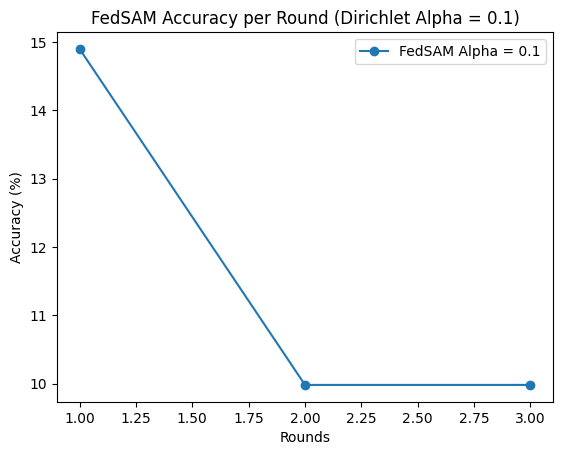

In [38]:
# Plotting accuracy per round for FedSAM with Dirichlet alpha 0.1
plt.figure()
plt.plot(range(1, rounds + 1), sam_accuracies, marker='o', label='FedSAM Alpha = 0.1')
plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.title('FedSAM Accuracy per Round (Dirichlet Alpha = 0.1)')
plt.legend()
plt.show()